In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

In [3]:
traces = []

In [4]:
chains = 4
cores = 4
draws = 6000
tune = 5000

seed = 235698

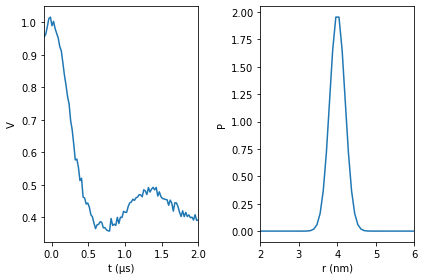

In [5]:
nr = 50
nt = 100

t = np.linspace(-0.1,2,nt)        # time axis, µs
r = np.linspace(2,6,nr)      # distance axis, ns

param = [4, 0.2] # parameters for three-Gaussian model
P0 = dl.dd_gauss(r,param)          # model distance distribution

# param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
# P0 = dl.dd_gauss2(r,param2)  

lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dive.bg_exp(t,k)         # background decay
K = dive.dipolarkernel(t,r)    # kernel matrix

Vexp = dive.deerTrace(K@P0,B,V0,lam) + dl.whitegaussnoise(t,0.01,seed=0)

fig, ax = plt.subplots(1,2)
line1 = ax[0].plot(t, Vexp)
line2 = ax[1].plot(r, P0)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'V')
ax[1].set(xlim = [2,6], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

In [6]:
L = dl.regoperator(r,d=2)

LtL = np.dot(L.transpose(),L)

KtK = np.dot(K.transpose(),K)

In [7]:
param = [5, 0.8] # parameters for three-Gaussian model
PsingleGaussOff = dl.dd_gauss(r,param)          # model distance distribution

param = [4, 0.8] # parameters for three-Gaussian model
PbroadGauss = dl.dd_gauss(r,param)          # model distance distribution

param3 = [4, 0.6,0.3, 3, 0.6, 0.3, 5.5, 0.6, 0.3] # parameters for three-Gaussian model

PmultiGauss = dl.dd_gauss3(r,param3)          # model distance distribution

param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
P2G = dl.dd_gauss2(r,param2)  

Puniform = np.ones(r.shape)
Puniform = Puniform/sum(Puniform)/(r[1]-r[0])

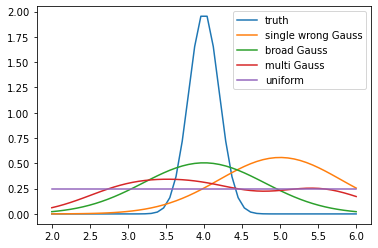

In [8]:
plt.plot(r, P0, label = "truth")
plt.plot(r, PsingleGaussOff, label = "single wrong Gauss")
plt.plot(r, PbroadGauss, label = "broad Gauss")
plt.plot(r, PmultiGauss, label = "multi Gauss")
plt.plot(r, Puniform, label = "uniform")
plt.legend()
plt.show()

In [9]:
Pmap = P0

## Sampling with a normalized P

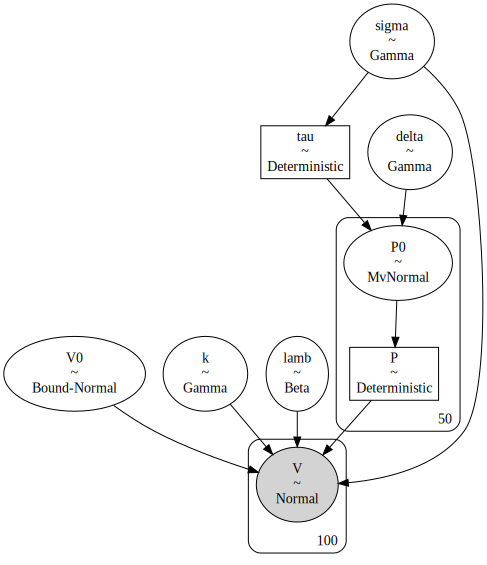

In [11]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)

    #  Distribution model
    delta = pm.Gamma('delta', alpha=0.7, beta=2)

    tau = pm.Deterministic('tau',1/(sigma*sigma))
    invSigma = (tau*KtK+delta*LtL)
    # invSigma = (tau*KtK)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)        
    # P0 = pm.Bound(pm.MvNormal, lower=0.0)("P0", mu=Pmap, chol = C_L, shape = nr)  
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))
    
    # Background
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dive.bg_exp(t,k)

    # DEER Signal
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    Vmodel = dive.deerTrace(pm.math.dot(K,P),B,V0,lamb)
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model)

In [10]:
trace = pm.sample(model = model,chains=chains, cores=cores, draws=draws, tune=tune,return_inferencedata=False,random_seed=seed)
traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [V0, lamb, k, P0, delta, sigma]


Sampling 4 chains for 5_000 tune and 6_000 draw iterations (20_000 + 24_000 draws total) took 1671 seconds.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3280 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1398545875673445, but should be close to 0.8. Try to increase the number of tuning steps.
There were 588 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5097173055300238, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
pm.save_trace(trace = trace, directory = './normalized.trace')

'./normalized.trace'

In [12]:
trace2 = pm.load_trace('./normalized.trace', model = model)
trace1 = pm.load_trace('./uniformprior.trace', model = model)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
k     0.004   0.006    0.000    0.016      0.000    0.000    2913.0    3796.0   
λ     0.593   0.012    0.571    0.616      0.000    0.000    3195.0    6424.0   
V₀    1.055   0.022    1.012    1.094      0.000    0.000    2227.0    7374.0   
σ     0.059   0.004    0.052    0.068      0.000    0.000    6502.0   11478.0   
τ   289.623  41.591  214.131  369.426      0.508    0.359    6502.0   11478.0   
δ     0.061   0.093    0.000    0.243      0.010    0.007     115.0     121.0   

    r_hat  
k    1.00  
λ    1.00  
V₀   1.00  
σ    1.00  
τ    1.00  
δ    1.06

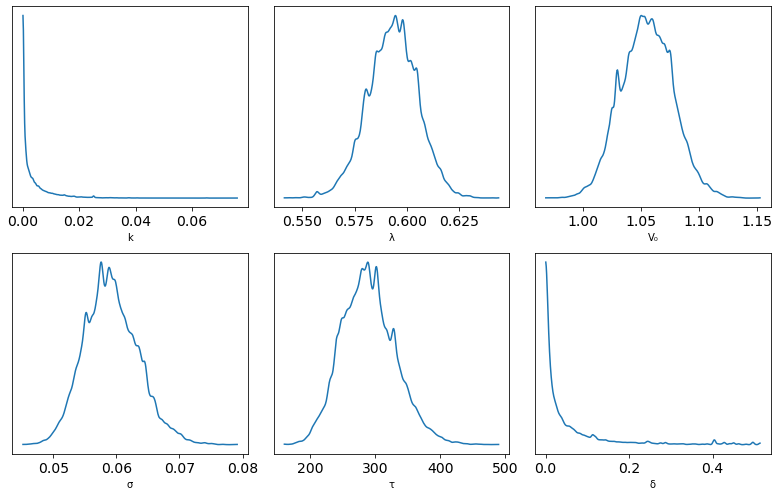

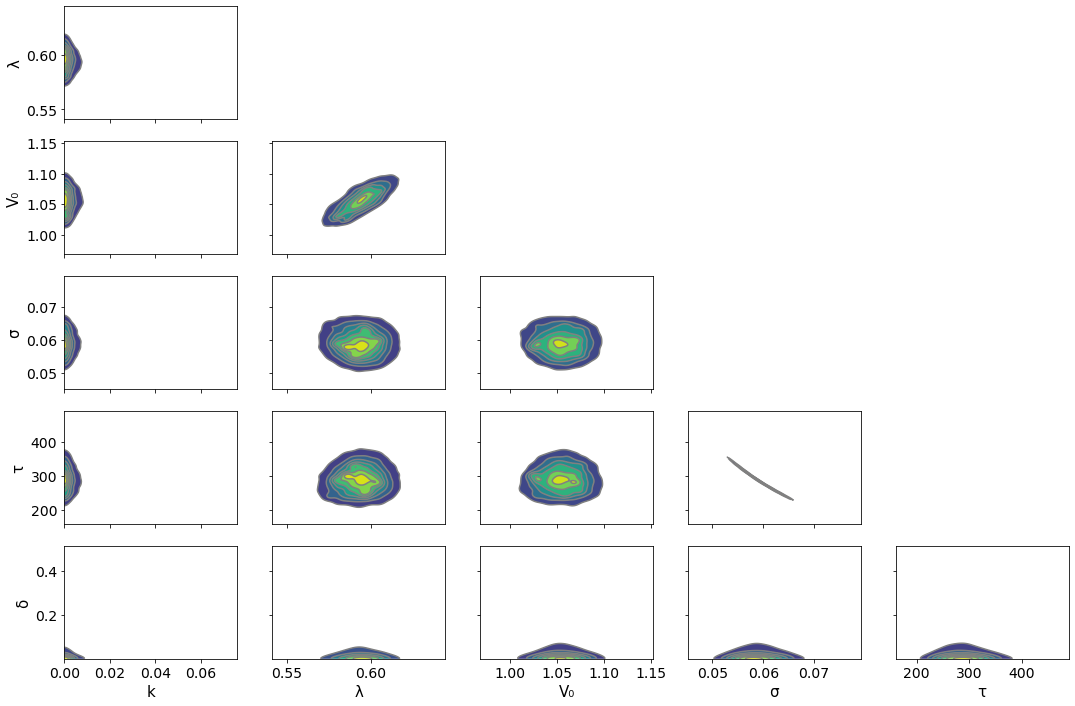

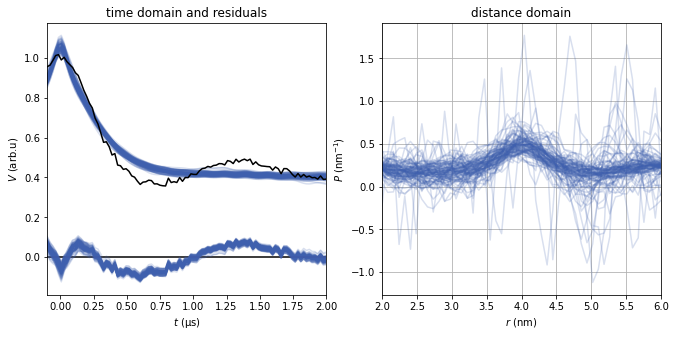

In [15]:
dive.summary(trace1,model,Vexp,t,r)

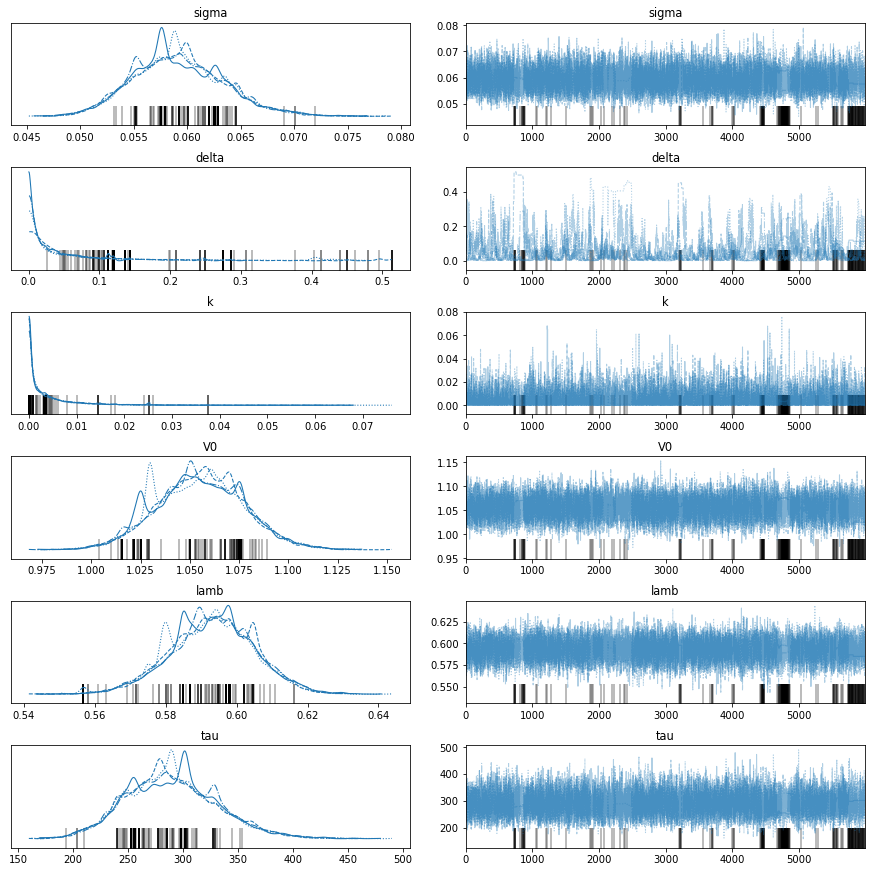

In [15]:
with model:
    az.plot_trace(trace,var_names=["sigma", "delta","k","V0","lamb","tau"])

## Sampling without normalization

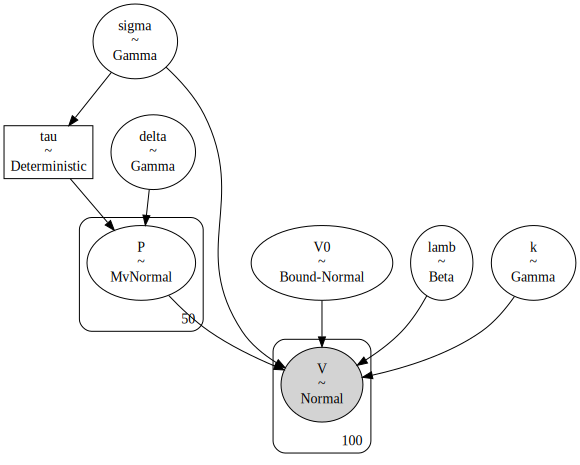

In [12]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)

    #  Distribution model
    delta = pm.Gamma('delta', alpha=0.7, beta=2)

    tau = pm.Deterministic('tau',1/(sigma*sigma))
    invSigma = (tau*KtK+delta*LtL)
    # invSigma = (tau*KtK)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P = pm.MvNormal("P", mu=Pmap, chol = C_L, shape = nr)        
    # P0 = pm.Bound(pm.MvNormal, lower=0.0)("P0", mu=Pmap, chol = C_L, shape = nr)  
    # P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))
    
    # Background
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dive.bg_exp(t,k)

    # DEER Signal
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    Vmodel = dive.deerTrace(pm.math.dot(K,P),B,V0,lamb)
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model)

In [16]:
trace = pm.sample(model = model,chains=chains, cores=cores, draws=draws, tune=tune,return_inferencedata=False,random_seed=seed)
traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [V0, lamb, k, P, delta, sigma]


In [ ]:
pm.save_trace(trace = trace,directory = './not_normalized.trace')

In [ ]:
dive.summary(trace,model,Vexp,t,r)

In [ ]:
with model:
    az.plot_trace(trace,var_names=["sigma", "delta","k","V0","lamb","tau"])